# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9).

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

In [ ]:
print("Please wait for ~8 seconds for the GPU session initialization. \n \
==> Please select both images at the same time after clicking \"Choose Files\".")
!mkdir -p /content/uploaded/ && rm -rf /content/uploaded/* # clear previously uploaded images
%cd /content/uploaded/
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
image_pair = ['/content/uploaded/' + f for f in list(uploaded.keys())]
%cd ..

# Change the image type here.
#image_type = 'indoor'
image_type = 'outdoor'

Please wait for ~8 seconds for the GPU session initialization. 
 ==> Please select both images at the same time after clicking "Choose Files".
/content/uploaded


Saving 5.jpg to 5.jpg
Saving 1.jpg to 1.jpg
User uploaded file "5.jpg" with length 44212 bytes
User uploaded file "1.jpg" with length 75581 bytes
/content


You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [ ]:
#img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
#img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
#image_pair = [img0_pth, img1_pth]
#image_pair = [img1_pth, img0_pth]

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
!gdown https://drive.google.com/uc?id=1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O -O indoor_ds.ckpt # indoor-ds
!gdown https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY -O outdoor_ds.ckpt # outdoor-ds
%cd ..

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

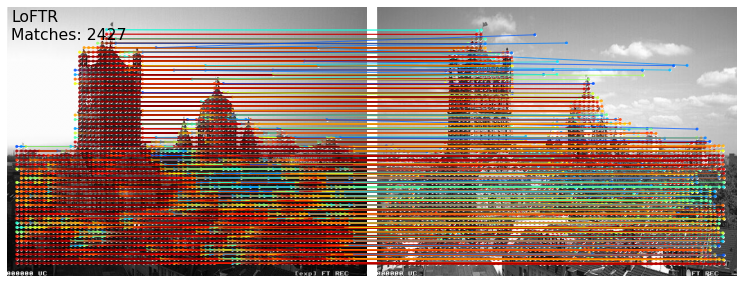

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
files.download("LoFTR-colab-demo.pdf")